### 4 states lumped model
This is P2X7 channel gating model


      
            C12   b1f ->  <- b1b  Q12
     s2f up ||  s2b down   d1f up || d1b down
            C34   s1b ->  <- s1f  Q34

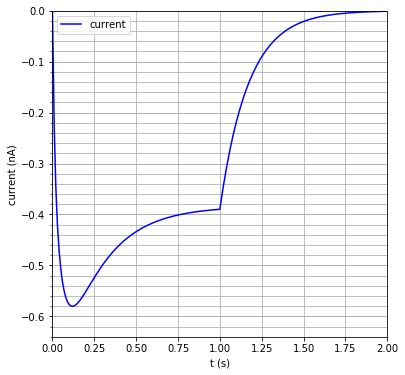

In [113]:
# Function for integreating ODE and displaying results
import scipy.integrate
from scipy.integrate import odeint
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import numpy.random as npr
# normal random distribution
from numpy.random import normal as nprn
# uniform random distribution
from numpy.random import uniform as npru

def f(y,t,a):
    return np.dot(a,y)

def null(a, rtol=1e-5):
    u, s, v = np.linalg.svd(a)
    rank = (s > rtol*s[0]).sum()
    return rank, v[rank:].T.copy()

# generate random reaction rate constants
def ksr():
   # Original rxn constants = nprn -> normal random distribution (avg, std) reported by Yan et al.
    k1 = nprn(0.3,0.03)
    k2 = nprn(40000,4000)
    k3 = nprn(2.4,0.24)
    k4 = nprn(50000,5000)
    k5 = nprn(1.58,0.158)
    k6 = nprn(7000,700)
    L1 = 0.0001
    L2 = nprn(0.004,0.0004)
    L3 = npru(0.1,0.3) # reported that this value was kept at 0.1 when ATP conc is 10 microM
    L4 = 0.0000000000000001 # supposedly zero
    return k1, k2, k3, k4, k5, k6, L1, L2, L3, L4

def f(y,t,a):
    return np.dot(a,y)

def null(a, rtol=1e-5):
    u, s, v = np.linalg.svd(a)
    rank = (s > rtol*s[0]).sum()
    return rank, v[rank:].T.copy()

# generate random conductance constance
def gr():
    g12 = nprn(1.5e-08,1.5e-09)
    g34 = nprn(4.5e-08,4.5e-09)
    V = -60e-3
    E = 0
    return g12, g34, V ,E

def lumpedK(A,r):

    if r == 1:
        k = ksr()
    elif r == 0:
        #k = np.array([50, 240000, 10, 2000000, 15, 200000, 73000, 12, 3, 500, 800000, 900000, 0.1, 1, 100, 50])####
        #k = np.array([50, 240000, 12, 2000000, 15, 200000, 70000, 6, 2.1, 500, 100000, 900000, 0.1, 1, 100, 50])
        k = np.array([50, 210000, 12, 2000000, 15, 200000, 70000, 12, 2.9, 500, 800000, 900000, 0.1, 1, 100, 50])
        
    r1 = 3*k[1]*A     # 3k2A  C1 -> C2
    r2 = k[15]        # L4    C1 -> C4
    r3 = k[0]         # k1    C2 -> C1
    r4 = 2*k[3]*A     # 2k4A  C2 -> Q1
    r5 = 2*k[2]       # 2k3   Q1 -> C2
    r6 = k[5]*A       # k6A   Q1 -> Q2   
    r7 = 3*k[4]       # 3k5   Q2 -> Q1
    r8 = k[14]        # L3    Q2 -> Q3
    r9 = k[13]        # L2    Q3 -> Q2
    r10 = 3*k[7]      # 3k8   Q3 -> Q4
    r11 = k[10]*A     # k11A  Q4 -> Q3
    r12 = 2*k[8]      # 2k9   Q4 -> C3
    r13 = 2*k[6]*A    # 2k7A  C3 -> Q4
    r14 = k[9]        # k10   C3 -> C4
    r15 = 3*k[11]*A   # 3k12A C4 -> C3
    r16 = k[12]       # L1    C4 -> C1

    # lumping process
    hk2 = r1/r3 #
    bk2 = r6/r7
    dk2 = r10/r11 #
    sk2 = r14/r15 #
        
    h1f = r16 
    h1b = r2/(1+hk2) #
    h2f = r4/(1+(1/hk2)) #
    h2b = r5

    b1f = h2f #
    b1b = h2b/(1+bk2) 
    b2f = r8/(1+(1/bk2)) 
    b2b = r9

    d1f = b2f 
    d1b = b2b/(1+dk2) # 
    d2f = r12/(1+(1/dk2)) #
    d2b = r13 #

    s1f = d2f #
    s1b = d2b/(1+sk2) # 
    s2f = h1f/(1+(1/sk2)) # 
    s2b = h1b #
        
    # Jacobian             
    J = np.array([
        [-(b1f+s2b), s2f, b1b, 0],   #dc12/dt = - (b1f+s2b)C12 + s2fC34 + b1bQ12 + 0Q34
        [s2b, -(s2f+s1b), 0, s1f],   #dc34/dt = s2bC12 - (s2f+s1b)C34 + 0Q12 + s1fQ34
        [b1f, 0, -(b1b+d1f), d1b],   #dq12/dt = b1fC12 + 0C34 - (b1b+d1f)Q12 + d1bQ34
        [0, s1b, d1f, -(d1b+s1f)]    #dq34/dt = 0C12 + s1bC34 + d1fQ12 - (s1f+d1b)Q34
    ])
    return J

def m4state(du,r,steps,ATP,ts,p):
    # du = duration
    # steps = number of frams between time intervals
    # r = switch to randomize rate constant: r = 0 -> off, r = 1 -> on
    # ATP = ATP concentration in M
    # ts = time interval size 
    # p = ATP duration time period
    
    global y1
    
    # empty matrix to store data
    c12 = []
    c34 = []
    q12 = []
    q34 = []
    I = []
    time = []
    
    iters = np.arange(du)

    for i in iters:
        
        t = scipy.linspace(i,(i+ts),steps)
        A = ATP*(1e-6)
        
        if i == p:
            A = 0.0000000000000000000000001
            
        # Generation of Jacobian
        J = lumpedK(A,r)

        if i == 0:
            y0 = np.array([1,0,0,0],dtype=np.float)
            y1 = scipy.integrate.odeint(f,y0,t,args=(J,))
        else:
            y0 = np.array([y1[-1,0],y1[-1,1],y1[-1,2],y1[-1,3]],dtype=np.float)
            y1 = scipy.integrate.odeint(f,y0,t,args=(J,))
        
        # Storing the obtaind/estimated concentration of each state
        iters2 = np.arange((steps)) # the final value of iters2 is (steps-1)
        y1 = np.array(y1)
       
        for d in iters2:
            if r == 1:
                g = gr() # Enables to apply random conductance for individual concentration value 
            elif r == 0:
                g = np.array([1.5e-08,4.5e-08,-60e-3,0])
                
            if d == iters2[(steps-1)]: # the last value is ignored
                break
            
            # Storing concentrations and time
            c12 = np.append(c12,y1[d,0])
            c34 = np.append(c34,y1[d,1])
            q12 = np.append(q12,y1[d,2])
            q34 = np.append(q34,y1[d,3])
            time = np.append(time,t[d])
            
            # Calculating and storing current information
            dummy = (g[0]*y1[d,2]*(g[2]-g[3])+g[1]*y1[d,3]*(g[2]-g[3]))/(1e-9)
            I = np.append(I,dummy)
            
            dummy = None
            g = None

        # Clear the variables used above
        y0 = None
        J = None
        iters2 = None
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_yticks(np.arange(-0.7,0.02,0.02), minor=True)
    ax.grid(which='both')
    ax.set_xlim([0,2])
    ax.set_ylim([-0.64,0])
    #plt.subplot(211)
    #plt.plot(time,c12,"b-",label="C12")
    #plt.plot(time,c34,"r-",label="C34")
    #plt.plot(time,q12,"g-",label="Q12")
    #plt.plot(time,q34,"m-",label="Q34")
    #plt.ylabel("concentration (M)")
    #plt.xlabel("t (s)")
    #plt.legend(loc=0)
    
    #plt.subplot(212)
    plt.plot(time,I,"b-",label="current")
    plt.ylabel("current (nA)")
    plt.xlabel("t (s)")
    plt.legend(loc=0)
    
    return c12, c34, q12, q34, I, time
ckr = m4state(2,0,101,30,1,1)

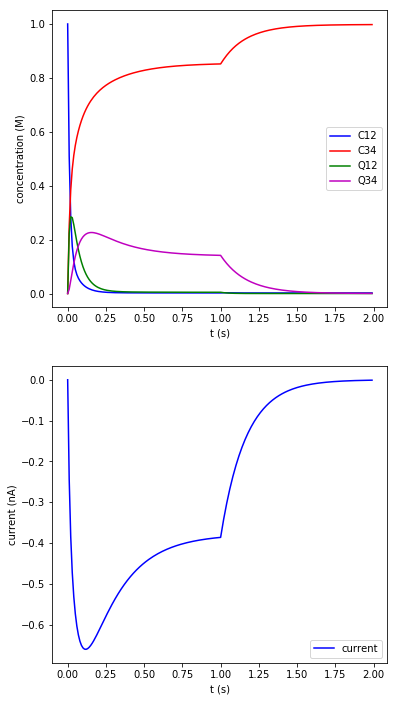

In [26]:
# Rxn rates and conductances are constant
# m4state(duration,randomization(r=0 off, r=1 on),num_of_steps,ATP conc in microM,time interval)
ckr = m4state(2,0,101,30,1,1) 

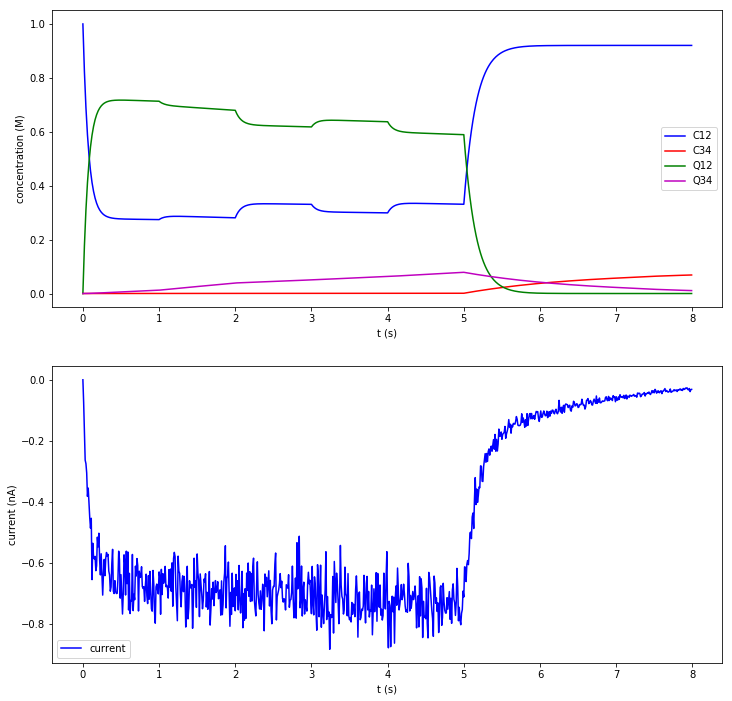

In [16]:
# Rxn rates and conductances are random
# m4state(duration,randomization(r=0 off, r=1 on),num_of_steps,ATP conc in microM,time interval in second)
rkr = m4state(8,1,101,100,1)